# Compression Test

Compression evaluation based on the Hertzian Model

In [1]:
from isaacsim import SimulationApp
simulation_app = SimulationApp({"headless": False})

import numpy as np
import matplotlib.pyplot as plt
import csv
import torch

from isaacsim.core.api import World
from isaacsim.core.api.objects import DynamicSphere
from isaacsim.core.api.materials.deformable_material import DeformableMaterial
from isaacsim.core.prims import SingleDeformablePrim
from isaacsim.core.utils import deformable_mesh_utils
from isaacsim.sensors.physics import ContactSensor
from omni.physx.scripts import physicsUtils
from pxr import UsdGeom, UsdPhysics



Starting kit application with the following args:  ['/home/rjrosales/Simulation/Custom_IsaacSim/_build/linux-x86_64/release/exts/isaacsim.simulation_app/isaacsim/simulation_app/simulation_app.py', '/home/rjrosales/Simulation/Custom_IsaacSim/_build/linux-x86_64/release/apps/isaacsim.exp.base.python.kit', '--/app/tokens/exe-path=/home/rjrosales/Simulation/Custom_IsaacSim/_build/linux-x86_64/release/kit', '--/persistent/app/viewport/displayOptions=3094', '--/rtx/materialDb/syncLoads=True', '--/rtx/hydra/materialSyncLoads=True', '--/omni.kit.plugin/syncUsdLoads=True', '--/app/renderer/resolution/width=1280', '--/app/renderer/resolution/height=720', '--/app/window/width=1440', '--/app/window/height=900', '--/renderer/multiGpu/enabled=True', '--/app/fastShutdown=False', '--/app/installSignalHandlers=0', '--ext-folder', '/home/rjrosales/Simulation/Custom_IsaacSim/_build/linux-x86_64/release/exts', '--ext-folder', '/home/rjrosales/Simulation/Custom_IsaacSim/_build/linux-x86_64/release/apps', '

### Simulation parameters

In [2]:
### USER CONSTANTS ###
BLOCK_SIZE = 0.30        # deformable cube edge in meters
SPHERE_RADIUS = 0.10     # sphere radius
DT = 1/60.0              # physics dt

CSV_TAG = "sphere_def_test"
CSV_FILE = f"{CSV_TAG}_results.csv"
PLOT_FILE = f"{CSV_TAG}_plot.png"


### GUI Panel

In [3]:
def create_world():
    world = World(stage_units_in_meters=1.0, backend="torch", device="cuda")
    world.scene.add_default_ground_plane()
    return world, world.stage


def create_deformable_block(world):
    mesh_path = "/DeformableBlock"

    tri_points, tri_indices = deformable_mesh_utils.createTriangleMeshCube(6)
    tri_points = (np.array(tri_points) * BLOCK_SIZE).tolist()

    mesh = UsdGeom.Mesh.Define(world.stage, mesh_path)
    mesh.GetPointsAttr().Set(tri_points)
    mesh.GetFaceVertexIndicesAttr().Set(tri_indices)
    mesh.GetFaceVertexCountsAttr().Set([3] * (len(tri_indices) // 3))

    physicsUtils.setup_transform_as_scale_orient_translate(mesh)
    physicsUtils.set_or_add_translate_op(mesh, (0.0, 0.0, BLOCK_SIZE/2))

    deform_mat = DeformableMaterial(
        prim_path="/World/DeformMat",
        youngs_modulus=6e4,
        poissons_ratio=0.45,
        dynamic_friction=0.4,
        damping_scale=0.05,
        elasticity_damping=0.05,
    )

    deformable = SingleDeformablePrim(
        prim_path=mesh_path,
        name="def_block",
        deformable_material=deform_mat,
        simulation_hexahedral_resolution=2,
        solver_position_iteration_count=30,
        collision_simplification=True,
        self_collision=True,
    )

    world.scene.add(deformable)
    print("🟦 Deformable block added")
    return deformable

def create_dynamic_sphere(world):
    return world.scene.add(
        DynamicSphere(
            prim_path="/Sphere",
            name="sphere",
            radius=SPHERE_RADIUS,
            position=np.array([0, 0, 0.20]),
            mass=1.0,
            color=np.array([255,255,0])
        )
    )



In [4]:
def attach_contact_sensor(world):
    sensor = world.scene.add(
        ContactSensor(
            prim_path="/Sphere/sensor",
            name="sphere_sensor",
            radius=0.12,
            min_threshold=0.0,
            max_threshold=1e6,
        )
    )
    sensor.add_raw_contact_data_to_frame()
    return sensor

def create_prismatic_joint(stage):
    joint = UsdPhysics.PrismaticJoint.Define(stage, "/World/JointZ")
    joint.CreateAxisAttr("Z")
    joint.CreateLowerLimitAttr(0.0)
    joint.CreateUpperLimitAttr(2.0)

    xform = UsdGeom.Xform.Define(stage, "/World/Ref")
    joint.CreateBody0Rel().SetTargets(["/World/Ref"])
    joint.CreateBody1Rel().SetTargets(["/Sphere"])

    drive = UsdPhysics.DriveAPI.Apply(joint.GetPrim(), "linear")
    drive.CreateTypeAttr().Set("position")
    drive.CreateStiffnessAttr().Set(45000)
    drive.CreateDampingAttr().Set(4000)

    return drive

### Joint Definition

In [5]:
def create_prismatic_joint(stage):
    joint = UsdPhysics.PrismaticJoint.Define(stage, "/World/JointZ")
    joint.CreateAxisAttr("Z")
    joint.CreateLowerLimitAttr(0.0)
    joint.CreateUpperLimitAttr(1.5)

    xform = UsdGeom.Xform.Define(stage, "/World/Ref")
    joint.CreateBody0Rel().SetTargets(["/World/Ref"])
    joint.CreateBody1Rel().SetTargets(["/Sphere"])

    drive = UsdPhysics.DriveAPI.Apply(joint.GetPrim(), "linear")
    drive.CreateTypeAttr().Set("position")
    drive.CreateStiffnessAttr().Set(40000)
    drive.CreateDampingAttr().Set(5000)

    return drive, joint.GetPrim()


### Simulation Loop

In [6]:
def attach_contact_sensor(world):
    sensor = world.scene.add(
        ContactSensor(
            prim_path="/Sphere/sensor",
            name="sphere_sensor",
            radius=0.12,
            min_threshold=0.0,
            max_threshold=1e6,
        )
    )
    sensor.add_raw_contact_data_to_frame()
    return sensor

def create_prismatic_joint(stage):
    joint = UsdPhysics.PrismaticJoint.Define(stage, "/World/JointZ")
    joint.CreateAxisAttr("Z")
    joint.CreateLowerLimitAttr(0.0)
    joint.CreateUpperLimitAttr(2.0)

    xform = UsdGeom.Xform.Define(stage, "/World/Ref")
    joint.CreateBody0Rel().SetTargets(["/World/Ref"])
    joint.CreateBody1Rel().SetTargets(["/Sphere"])

    drive = UsdPhysics.DriveAPI.Apply(joint.GetPrim(), "linear")
    drive.CreateTypeAttr().Set("position")
    drive.CreateStiffnessAttr().Set(45000)
    drive.CreateDampingAttr().Set(4000)

    return drive

In [7]:
def run_test(world, drive, sensor, sphere):
    time_log, disp_log, force_log = [], [], []
    sim_time = 0.0
    target, direction = 1.5, -1

    print("⏵ Ready — Press PLAY in Isaac Sim to start")

    while simulation_app.is_running():

        if world.is_playing():

            sim_time += DT
            time_log.append(sim_time)

            target += 0.001 * direction
            if target <= 0.35: direction = +1
            elif target >= 1.2: direction = -1

            drive.GetTargetPositionAttr().Set(target)
            disp_log.append(sphere.get_world_pose()[0][2])

            frame = sensor.get_current_frame()
            fn = abs(frame["force"][2]) if frame["in_contact"] else 0.0
            force_log.append(fn)

        if world.is_stopped() and len(time_log) > 5:
            print("⏹ STOP detected → Test complete")
            return time_log, disp_log, force_log

        world.step(render=True)


### Data Logging

In [8]:
def save_csv(time, disp, force):
    with open(CSV_FILE, "w", newline="") as f:
        w = csv.writer(f)
        w.writerow(["time_s", "sphere_z_m", "normal_force_N"])
        for t, z, fn in zip(time, disp, force):
            w.writerow([t, z, fn])
    print("🧾 CSV saved →", CSV_FILE)

def save_plot(time, disp, force):

    def to_np(x):
        if isinstance(x, torch.Tensor):
            return x.detach().cpu().numpy()
        if isinstance(x, (list, tuple)):
            return np.array([to_np(v) for v in x])
        return np.array(x)

    time  = to_np(time)
    disp  = to_np(disp)
    force = to_np(force)

    plt.figure(figsize=(7,4))
    plt.plot(disp, force, linewidth=2)
    plt.xlabel("Sphere Displacement (m)")
    plt.ylabel("Normal Force (N)")
    plt.title("Sphere Compression — Force vs Displacement")
    plt.grid(True)
    plt.tight_layout()
    plt.savefig(PLOT_FILE, dpi=300)
    plt.show()

    print("📈 Plot saved →", PLOT_FILE)




In [9]:
world, stage = create_world()
block = create_deformable_block(world)
sphere = create_dynamic_sphere(world)
sensor = attach_contact_sensor(world)
drive = create_prismatic_joint(stage)

world.reset()



In [10]:
frame = sensor.get_current_frame()
frame.keys()


dict_keys(['time', 'physics_step', 'contacts', 'in_contact', 'force', 'number_of_contacts'])

In [11]:
time, disp, force = run_test(world, drive, sensor, sphere)

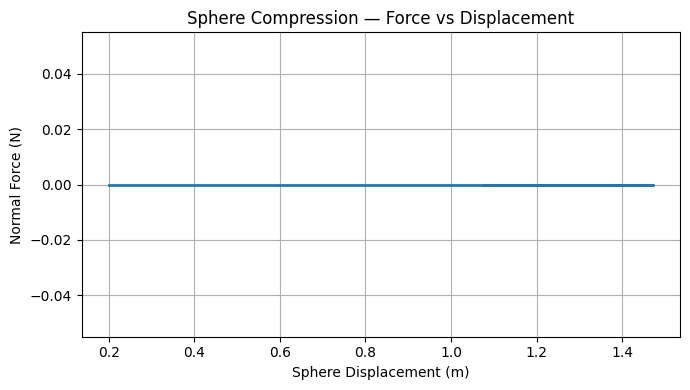

In [12]:
# save_csv(time, disp, force)
save_plot(time, disp, force)

In [3]:
simulation_app.close()

NameError: name 'disp' is not defined